<a id="top"></a>
# HST Exception Report - Investigate your ACS Data
***
## Learning Goals
In this notebook, we will walk through steps to check your ACS data and observing logs for possible data quality problems indicated by an HST Exception Report and determine if a HOPR or Help Desk ticket needs to be filed.

By the end of this notebook, you will learn to:
- Download your data
- Display the data
- Check data quality and any anomalies
- Inspect JIF header keywords for problems
- Run hst1pass on your data and evaluate the results
- Determine if a HOPR or help desk ticket is warranted

## Table of Contents

[0. Introduction](#intro) <br>
[1. Imports](#imports) <br>
[2. Download data](#download) <br>
[3. View data](#view) <br>
[4. Inspect JIF header keywords](#inspect) <br>
[5. Check jitter](jitter) <br>
[6. Check PSF quality with hst1pass (Optional)](#hst1pass) <br>
[7. Summary & Additional Resources](#summary) <br>
[About this Notebook](#about) <br>
[Citations](#citations)

## 0. Introduction <a id="intro"></a>
[HST exception reports](https://www.stsci.edu/hst/observing/post-observation/exception-reports) are sent via email to the PIs of programs that encounter observing problems during a given visit. Often times these are due to guide star acquisition failures, but there can be other causes, including unexpected safings of the telescope. Sometimes a report is sent out of an abundance of caution, in that the observing problem in question did not affect the data in the exception report. If you receive one of these reports, it is highly recommended that you inspect your data and the observing logs immediately in order to determine if your data quality is affected in any way. 

If you determine your data are compromised by an observing problem, you can file a [Hubble Observation Problem Report (HOPR)](https://www.stsci.edu/hst/observing/post-observation/reporting-problems). There is a 90-day time limit from the date the data were made available to file a HOPR.

If you have any issues with this notebook or any further questions, please contact the [ACS Help Desk](https://stsci.service-now.com/hst).

Some text and code in this notebook was adapted from the [WFC3 Exception Report Checklist notebook (Kuhn 2022)](https://spacetelescope.github.io/hst_notebooks/notebooks/WFC3/exception_report/wfc3_exception_report.html).

## 1. Environment Setup and Imports <a id="imports"></a>

We recommend installing the `stenv` Conda environment maintained by STScI. Instructions, including installation of a Conda distribution, can be found in the [stenv documentation](https://stenv.readthedocs.io/en/latest/getting_started.html). If you already have Conda, and would prefer to create an environment with only the packages required by this notebook, please see the `requirements.txt` file included in this notebook's repository.

Finally, this notebook contains an optional step to check PSF quality with a Fortran software package `hst1pass`. Instructions to install Fortran, download and compile `hst1pass`, download a PSF model, and run `hst1pass` are provided in Step [6. Check PSF quality with hst1pass (Optional)](#hst1pass).

For the Python-based steps in this notebook, we import: <br>

| Package Name                        | Purpose                               |
|:------------------------------------|:--------------------------------------|
| `glob`                              | creating list of files                |
| `shutil`                            | directory clean up                    |
| `os`                                | setting environment variables         |
| `urllib`                            | downloading hst1pass files            |
| `astroquery.mast.Observations`      | downloading data from MAST            |
| `astropy.io.fits`                   | opening and modifying fits files      |
| `astropy.io.ascii`                  | reading text files                    |
| `astropy.visualization.simple_norm` | normalize image for display           |
| `matplotlib.pyplot`                 | plotting and displaying images        |

In [3]:
import glob
import shutil
import os
import urllib
from astroquery.mast import Observations
from astropy.io import fits, ascii
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt

## 2. Download data <a id="download"></a>

Here we download an example dataset with `astroquery.mast`. We choose visit 57 from program [16380 (PI Chiaberge)](https://www.stsci.edu/hst-program-info/program/?program=16380), which consists of three ACS/WFC observations: `JEG057010`, `JEG057020`, and `JEG057030`. Each contains two exposures. The target is a region of Omega Centauri, a Milky Way globular cluster, so successful exposures contain a large population of resolved stars. We download the FLT, JIF, and JIT files, and move them into a directory named for the program ID. 

To use this notebook with your data, edit the cell below with your program ID and exposure IDs ([association names or IPPPSSOOTs](https://archive.stsci.edu/hlsp/ipppssoot.html)), which are listed in your exception report.

For more information on this method of downloading data, see the documentation for [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html). This list of [parameters](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html) for the `query_criteria()` function may be particularly useful. Other methods for downloading data include the [MAST HST Search](https://mast.stsci.edu/search/ui/#/hst) and the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html), the latter of which includes data from missions other than HST.

In [4]:
# Edit this cell with your info
program_id = 16380
exp_id = ['JEG057010', 'JEG057020', 'JEG057030']
data_products = ['FLT', 'JIF', 'JIT']

In [5]:
program_dir = '{}/p{}'.format(os.getcwd(), program_id)

# Check if directory for program exists already
try:
    os.mkdir(program_dir)
except Exception:
    print('Directory {} exists.\n'.format(program_dir))

# Check that all dataset names are 9 characters long
# if not, add a q to the end
datasets = ['{}q'.format(set) if len(set) == 8 else set for set in exp_id]

print('Visits to be downloaded')
print('{}\n'.format(datasets))

# Query MAST for datasets
obs_table = Observations.query_criteria(obs_id=datasets)
product_table = Observations.get_product_list(obs_table)
files_for_download = product_table['productFilename']
download_table = Observations.download_products(product_table, mrp_only=False,
                                                productSubGroupDescription=data_products)

# For convenience move downloaded files to program dir and remove empty download dir
for file in download_table['Local Path']:
    shutil.move(file, program_dir)
    
shutil.rmtree('mastDownload')

Directory /System/Volumes/Data/grp/hst/acs3/ryon/hst_notebooks/notebooks/ACS/acs_exception_report/p16380 exists.

Visits to be downloaded
['JEG057010', 'JEG057020', 'JEG057030']



KeyboardInterrupt: 

## 3. View data <a id="view"></a>
Next, we use `matplotlib.pyplot.imshow` to display the SCI arrays of the FLT images. We also print the filter information for each image at the top of the plot. In some cases, a quick visual inspection can reveal poor data quality due to guiding problems. In other cases, a deeper level of analysis is needed to determine if there are problems with the data.

In [6]:
flt_files = sorted(glob.glob(f'p{program_id}/*flt.fits'))

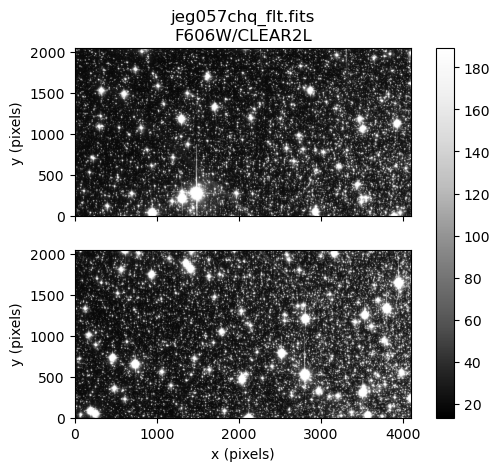

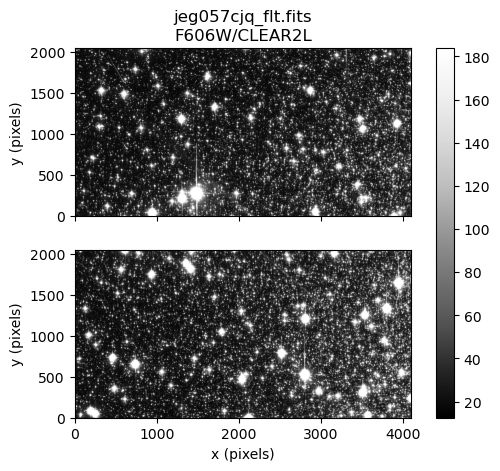

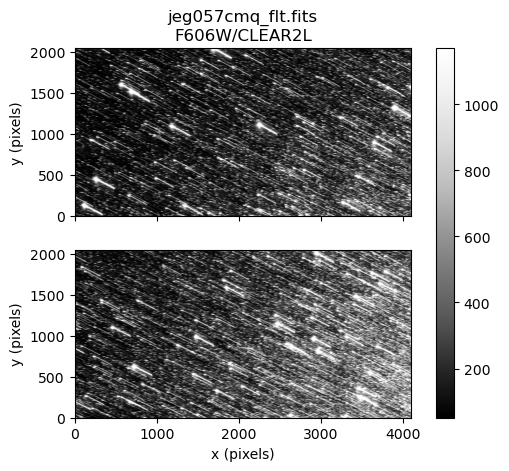

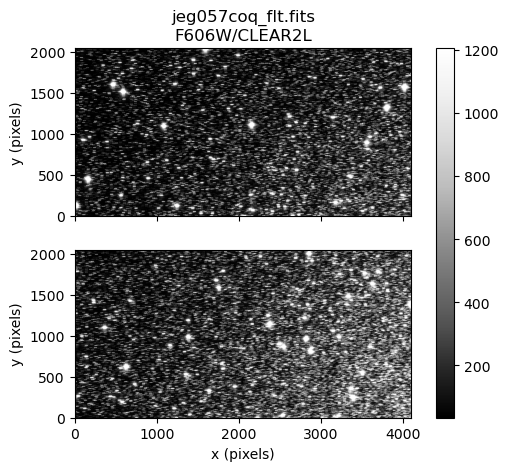

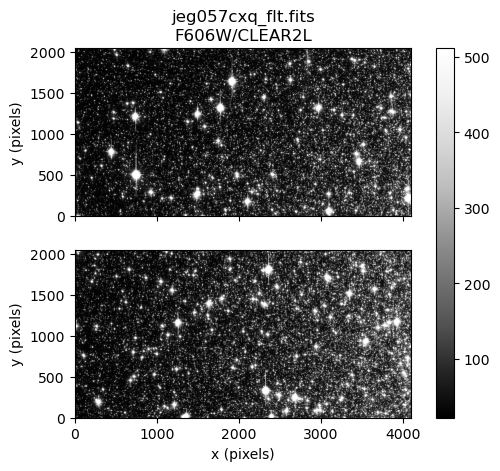

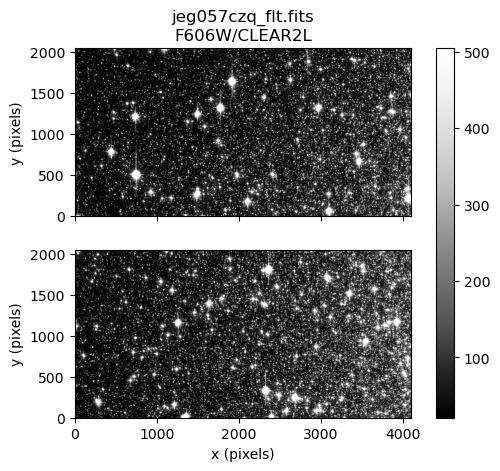

In [8]:
for flt in flt_files:

    hdu = fits.open(flt)
    hdr = hdu[0].header

    # Only 1 SCI extension for SBC images
    if hdr['DETECTOR'] == 'SBC':
        sci1 = hdu[1].data
            
        filter1 = hdr['FILTER1']

        norm = simple_norm(sci1, 'linear', percent=90)
        
        fig, ax0 = plt.subplots(1, 1)

        im = ax0.imshow(sci1, origin='lower', norm=norm, cmap='Greys_r')

        ax0.set_xlabel('x (pixels)')
        ax0.set_ylabel('y (pixels)')
        ax0.set_title(f'{flt.split("/")[-1]}\n{filter1}')
        fig.colorbar(im, ax=ax0)

    # 2 SCI extensions for WFC images
    elif hdr['DETECTOR'] == 'WFC':
        sci1 = hdu[4].data
        sci2 = hdu[1].data
        
        filter1 = hdr['FILTER1']
        filter2 = hdr['FILTER2']
        
        norm = simple_norm(sci1, 'linear', percent=90)

        fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)

        im = ax0.imshow(sci1, origin='lower', norm=norm, cmap='Greys_r')
        ax1.imshow(sci2, origin='lower', norm=norm, cmap='Greys_r')

        ax1.set_xlabel('x (pixels)')
        ax0.set_ylabel('y (pixels)')
        ax1.set_ylabel('y (pixels)')
        ax0.set_title(f'{flt.split("/")[-1]}\n{filter1}/{filter2}')
        fig.colorbar(im, ax=(ax0, ax1))

In this example, the third and fourth images, `jeg057cmq` and `jeg057coq`, consist of streaked stars. This is a very clear example of a guiding failure. The other images appear normal with many bright point-like stars in the field of view.

Often, the shutter will close if a guiding failure occurs. These images will not be blank, but will contain normal detector features such as cosmic rays and hot pixels.

## 4. Inspect JIF header keywords <a id="inspect"></a>

To further investigate any guiding issues in the dataset, we inspect certain header keywords in the [observing log (JIF) files](https://www.stsci.edu/hst/instrumentation/focus-and-pointing/pointing/jitter-file-format-definition). There are two JIF files, one for each association, each listing observing information for two exposures. There is a section in the zeroth extension of the JIF files that lists problem flags for the dataset, which we print and inspect first.

In [11]:
# Define color strings and expected JIF keyword values
colorstr_WARNING = '\033[91m' # red
colorstr_RESET = '\033[0m' # reset

jif_header_keys = {'T_GDACT': {'expected': True},
                   'T_ACTGSP': {'expected': True},
                   'T_GSFAIL': {'expected': False},
                   'T_SGSTAR': {'expected': False},
                   'T_TLMPRB': {'expected': False},
                   'T_NOTLM': {'expected': False},
                   'T_NTMGAP': {'expected': 0},
                   'T_TMGAP': {'expected': 0},
                   'T_GSGAP': {'expected': False},
                   'T_SLEWNG': {'expected': False},
                   'T_TDFDWN': {'expected': False}}

jif_list = sorted(glob.glob(f'p{program_id}/*jif.fits'))

for jif in jif_list:
    
    with fits.open(jif) as hdu:
        jif_hdr = hdu[0].header

    print(jif.split('/')[-1])

    # print section of JIF header with problem flags
    for i in range(-18, -7):
        key = list(jif_hdr.keys())[i]
        
        # Highlight unexpected values in red
        if jif_hdr[key] != jif_header_keys[key]['expected']:
            print(colorstr_WARNING + repr(jif_hdr[i:i+1]) + colorstr_RESET)        
        else:
            print(repr(jif_hdr[i:i+1]))
    print('\n')

jeg057011_jif.fits
T_GDACT =                    T / Actual guiding mode same for all exposures     
T_ACTGSP=                    T / Actual Guide Star Separation same in all exps. 
T_GSFAIL=                    F / Guide star acquisition failure in any exposure 
T_SGSTAR=                    F / Failed to single star fine lock                
T_TLMPRB=                    F / problem with the engineering telemetry in any e
T_NOTLM =                    F / no engineering telemetry available in all exps.
T_NTMGAP=                    0 / total number of telemetry gaps in association  
T_TMGAP =             0.000000 / total duration of missing telemetry in asn. (s)
T_GSGAP =                    F / missing telemetry during GS acq. in any exp.   
T_SLEWNG=                    F / Slewing occurred during observations           
T_TDFDWN=                    F / Take Data Flag NOT on throughout observations  


jeg057021_jif.fits
T_GDACT =                    T / Actual guiding mode same for all exp

The only problem flag in these JIF files is that `T_TDFDWN` is True in the second file, which is highlighted in red to show it is different than the expected value (False). This means that the Take Data Flag was down at some point during the third and fourth exposures. If the Take Data Flag is up, that means an observation can proceed. If it goes down, the observation may stop, shutters may close, and generally, no more science data is taken until the flag goes back up. Interestingly, the shutter clearly opened during the third and fourth exposures shown in the figures above.

We may expect `T_GSFAIL` to be True in the second JIF file, since the TDF went down, but it is False, suggesting that the guiding problem that led to streaked images likely happened before the exposures began.

Next, we look at the header keywords in the first and subsequent extensions of the JIF file to learn more about observing problems in the individual exposures.

In [12]:
def further_ext(jif_file):

    numexts = fits.getheader(jif_file, 0)['NEXTEND'] # number of extensions i.e. exposures

    keywords = ['EXPNAME*', 'GUIDEACT*', 'GSACQ*', 'ACTGSSEP*',
                'GSSEPRMS*', ' NLOSSES*',
                'V2_RMS*', 'V3_RMS*', 'GSFAIL*', 'TDF-DOWN*']

    for ext in range(1, numexts+1):
        print("JIF Header Ext Number:", ext)
        print('-'*80)
        header = fits.getheader(jif_file, ext)
        for keyword in keywords:
            # try to display keyword because it may not be present 
            details = header[keyword]
            if details is not None:
                print(repr(details))
            else:
                print(f'Keyword {keyword} not found in extension {ext}')
        print('\n')

In [13]:
for jif in jif_list:

    further_ext(jif)

JIF Header Ext Number: 1
--------------------------------------------------------------------------------
EXPNAME = 'jeg057chj                ' / exposure identifier                     
GUIDEACT= 'FINE LOCK           ' / Actual Guiding mode at end of GS acquisition 
GSACQ   = '2021.201:11:20:29   ' / Actual time of GS Acquisition Completion     
ACTGSSEP=             1092.737 / Actual Guide Star Separation (arcsec)          
GSSEPRMS=                  0.6 / RMS of Guide Star Separation (milli-arcsec)    

V2_RMS  =                  1.8 / dominant guide star V2 axis RMS (mas)          
V3_RMS  =                  1.4 / dominant guide star V3 axis RMS (mas)          




JIF Header Ext Number: 2
--------------------------------------------------------------------------------
EXPNAME = 'jeg057cjj                ' / exposure identifier                     
GUIDEACT= 'FINE LOCK           ' / Actual Guiding mode at end of GS acquisition 
GSACQ   = '2021.201:11:20:29   ' / Actual time of GS A

Keywords from the JIF files indicate that the third and fourth exposures were taken without a lock on guide stars. The actual guiding mode, `GUIDEACT`, was `GYRO`, meaning the guiding was controlled by the telescope gyro alone, which explains the detector motion. The guide star keywords `ACTGSSEP`, `GSSEPRMS`, `V2_RMS` and `V3_RMS` are set to the nonphysical value `-32767`, and `TDF-DOWN` is True. 

The other exposures had two guide stars acquired, as indicated by `GUIDEACT = FINE LOCK`. (When a single guide star is acquired, `GUIDEACT` is set to `FINE/GYRO`.) The guide star keywords `ACTGSSEP`, `GSSEPRMS`, `V2_RMS`, and `V3_RMS` are set to realistic, typical values.

## 5. Check jitter <a id="jitter"></a>

Sometimes the telescope may shake or move slightly during an observation, while guiding in `FINE LOCK`. This is called jitter. Motion of the detector in the V2, V3 coordinate system is saved in the jitter (JIT) file, and can be inspected for any extreme excursions that could affect data quality.

In [14]:
def jitter_plots(jit_file):
    
    numexts = fits.getheader(jit_file, 0)['NEXTEND'] 

    for ext in range(1, numexts+1):

        jit_data = fits.getdata(jit_file, ext)
        expname = fits.getheader(jit_file, ext)['EXPNAME']
        
        plt.figure()
        plt.grid(alpha=0.5)
        plt.scatter(jit_data['Seconds'], jit_data['SI_V2_AVG'], 15, 
                    alpha=0.5, marker='o', label='V2_AVG')
        plt.scatter(jit_data['Seconds'], jit_data['SI_V3_AVG'], 15, 
                    alpha=0.5, marker='o', label='V3_AVG')
        plt.scatter(jit_data['Seconds'], jit_data['SI_V2_RMS'], 10, 
                    alpha=0.5, marker='s', label='V2_RMS')
        plt.scatter(jit_data['Seconds'], jit_data['SI_V3_RMS'], 10, 
                    alpha=0.5, marker='s', label='V3_RMS')
        
        plt.xlabel('Exposure Time [Seconds]', size=13)
        plt.ylabel('Coordinate Axis [Arcsec]', size=13)
        plt.title(f"Jitter File Ext Number: {ext}\n Exposure: {expname}", size=14)
        plt.legend(ncol=2)
        plt.minorticks_on()

In [15]:
jit_list = sorted(glob.glob(f'p{program_id}/*jit.fits'))

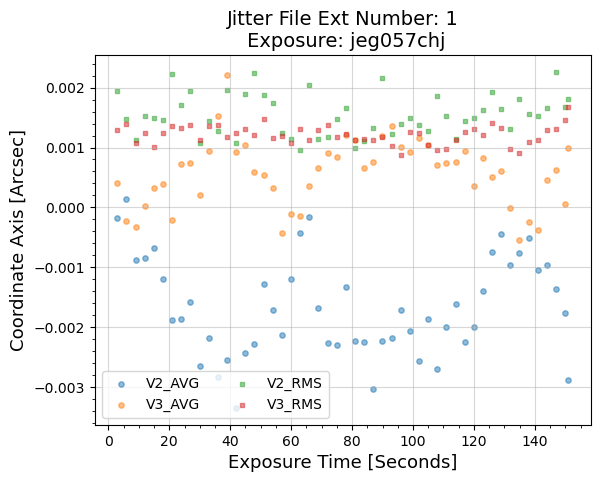

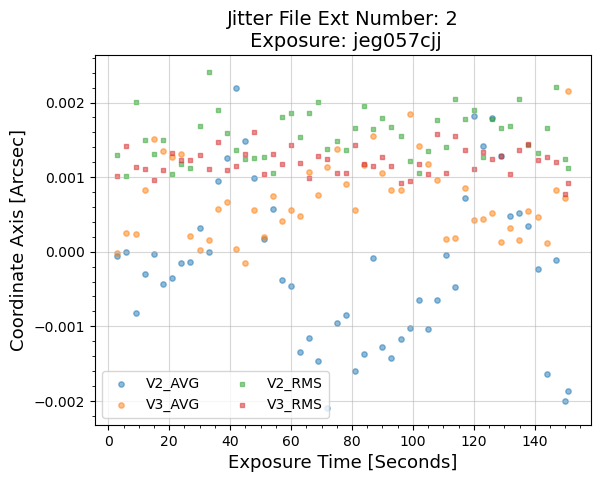

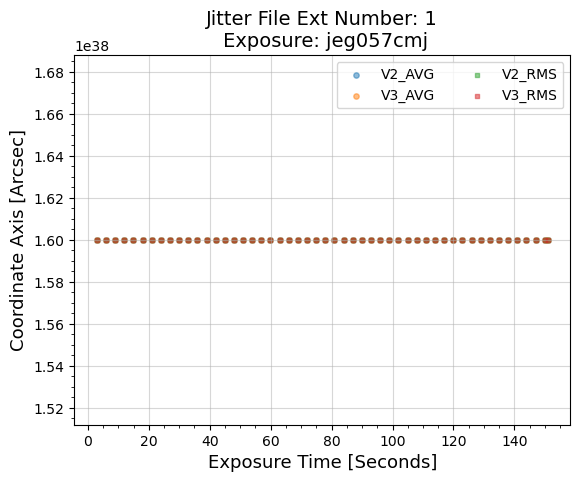

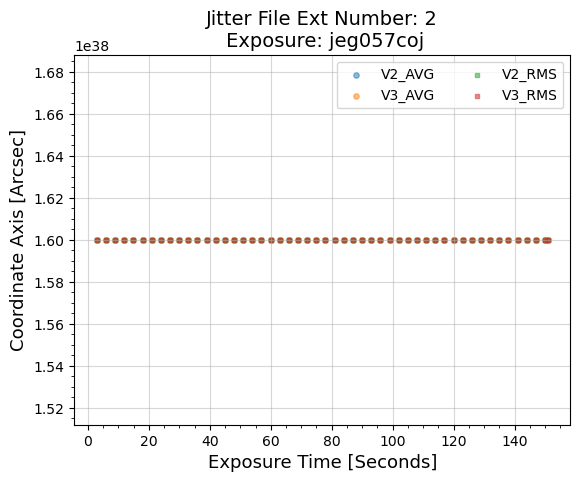

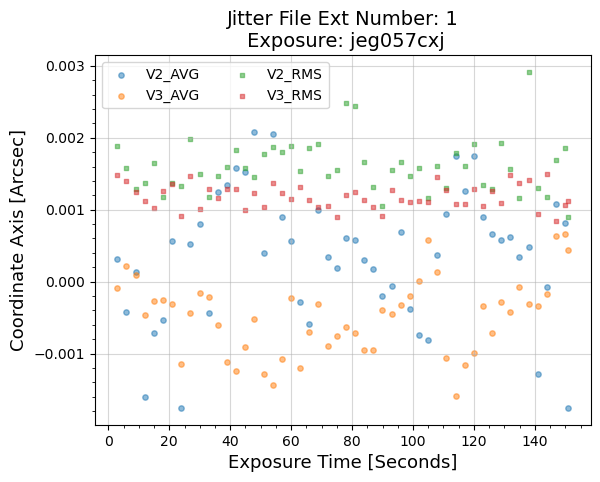

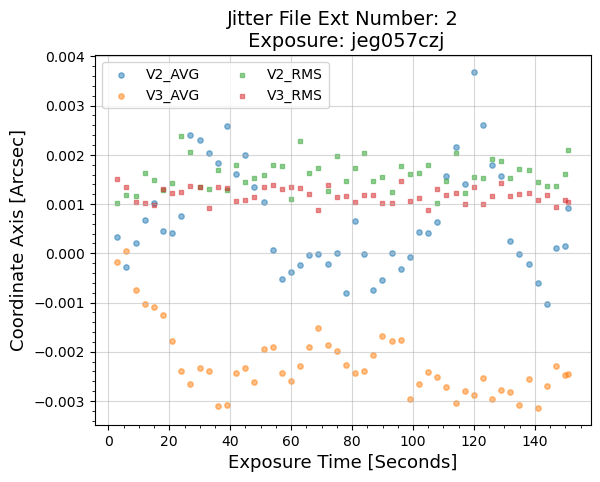

In [16]:
for jit in jit_list:
    
    jitter_plots(jit)

The third and fourth exposures have jitter values pegged at a nonphysical value of 1.6e38, which is simply a placeholder for observations in which the guide stars were not acquired. The remaining exposures show a very minor amount of telescope motion, typically <3 mas, and the jitter RMS is typically <2 mas.

This further confirms there were no guide stars acquired for the third and fourth images, but the remaining images were not affected by guide star problems. The above analysis is enough to determine that a HOPR is warranted for the two images for which the telescope was guiding in GYRO mode.

If data quality is still unclear at this point, proceeding to the next section may be useful. Another avenue for futher analysis that we recommend, radial profile fitting of stars, is thoroughly covered in Step 6 in the [WFC3 Exception Report Checklist notebook](https://spacetelescope.github.io/hst_notebooks/notebooks/WFC3/exception_report/wfc3_exception_report.html#further-analysis).

## (Optional) 6. Check PSF quality with hst1pass <a id="hst1pass"></a>

If your images have at least a handful of unsaturated stars, running the PSF-fitting photometry package [hst1pass](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2202.pdf) on your data can provide an independent check of PSF quality, and may help you decide if a HOPR is warranted.

### 6.1 Environment Setup

We first install Fortran by typing `conda install -c conda-forge gfortran` in the terminal. You may need to save and close this notebook, install Fortran, and then restart this notebook to ensure Fortran is active in your environment.

Next, we download the hst1pass Fortran package from [https://www.stsci.edu/~jayander/HST1PASS/CODE/hst1pass/](https://www.stsci.edu/~jayander/HST1PASS/CODE/hst1pass/) and compile it. Alternatively, this can be done manually by downloading the latest file from the website directly, and compiling it on the command line with the command `gfortran hst1pass.2025.02.14_v1h.F`. This is the most recent version of the Fortran package as of the writing of this notebook, so it would be prudent to check for a newer version on the website above.

In [17]:
file = 'hst1pass.2025.02.14_v1h.F'
file_url = f'https://www.stsci.edu/~jayander/HST1PASS/CODE/hst1pass/{file}'

# Download the fortran file if it doesn't exist
if not os.path.exists(f'./{file}'):
    print('Downloading:', file_url)
    urllib.request.urlretrieve(file_url, f'./{file}')

# Compile hst1pass if it hasn't been yet
if not os.path.exists('./hst1pass.e'):
    os.system(f'gfortran {file} -o hst1pass.e')
    print('The executable hst1pass.e has been compiled')
else:
    print('The executable hst1pass.e already exists')

Downloading: https://www.stsci.edu/~jayander/HST1PASS/CODE/hst1pass/hst1pass.2025.02.14_v1h.F
The executable hst1pass.e has been compiled


Next, we download the [standard library PSF](https://www.stsci.edu/~jayander/HST1PASS/LIB/PSFs/STDPSFs/) for the filter used for your data. See the figure titles in step 3 above for filter information: ACS/WFC F606W in this example. Note that PSFs are not available for all ACS filters, so that may limit your ability to complete this step.

In [20]:
psf_name = 'STDPSF_ACSWFC_F606W_SM4.fits'
psf_url = f'https://www.stsci.edu/~jayander/HST1PASS/LIB/PSFs/STDPSFs/ACSWFC/{psf_name}'

# Download the PSF file if it doesn't exist.
if not os.path.exists(f'./{psf_name}'):
    print('Downloading:', psf_url)
    urllib.request.urlretrieve(psf_url, f'./{psf_name}')

Downloading: https://www.stsci.edu/~jayander/HST1PASS/LIB/PSFs/STDPSFs/ACSWFC/STDPSF_ACSWFC_F606W_SM4.fits


### 6.2 Run hst1pass

Here we run hst1pass on the FLT files with a simple set of input parameters:
- `HMIN = 5` requires that a given pixel have no brighter pixels within 5 pixels radius
- `FMIN = 150` requires that source contain at least 150 electrons in a 2x2 pixel box
- `PSF` lists the PSF file
- `PERT = 1` allows the library PSF to be perturbed to find the single best PSF for a given image
- `OUT = xymeq` specifies the output quantities: detector coordinates `x` and `y`, instrumental magnitude and error `m` and `e`, and the quality of fit metric for the PSF fit `q`.

In [ ]:
for flt in flt_files:
    
    cmd = f'./hst1pass.e HMIN=5 FMIN=150 PSF=STDPSF_ACSWFC_F606W_SM4.fits \
            PERT=1 OUT=xymeq {flt}'
    os.system(cmd)

Now we read in the hst1pass output and plot the `q` metric as a function of instrumental magnitude `m`.

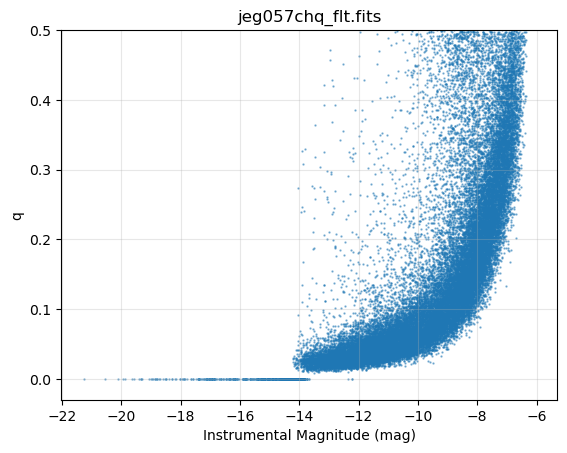

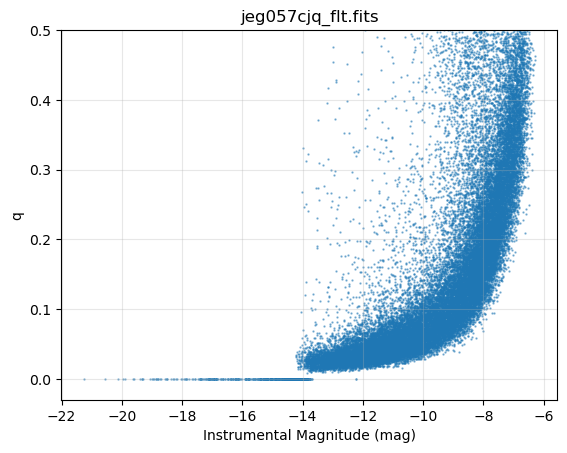

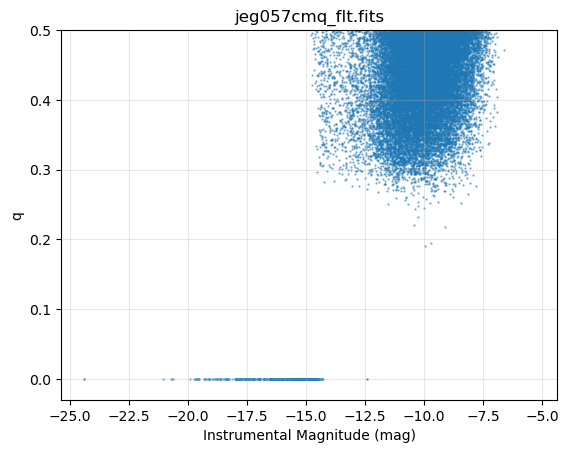

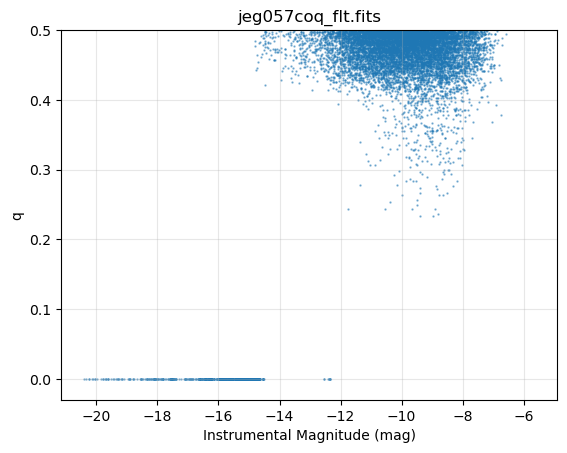

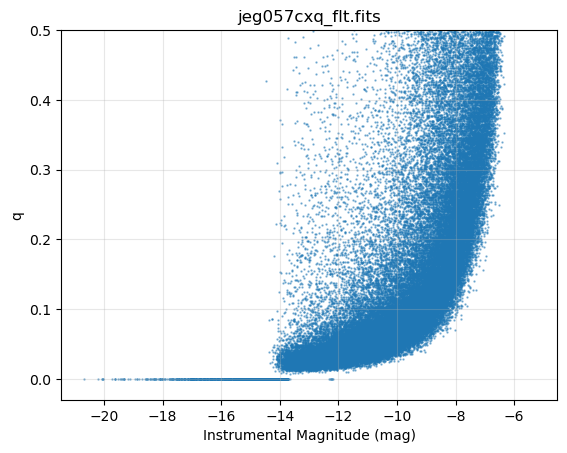

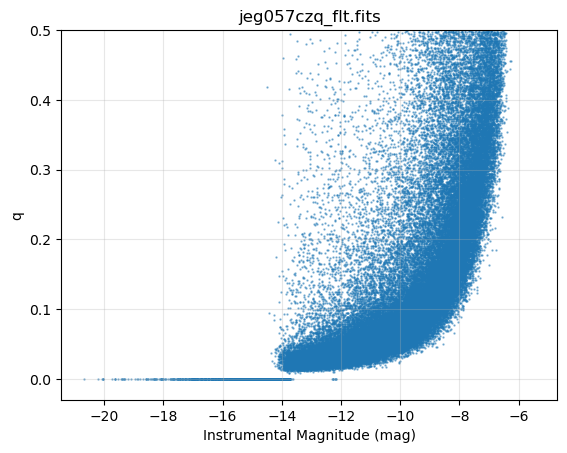

In [22]:
for flt in flt_files:

    root = flt.split('/')[-1].split('_flt.fits')[0]

    tab = ascii.read(f'{root}_flt.xymeq', names=['x', 'y', 'mag', 'error', 'q'])

    plt.figure()

    plt.scatter(tab['mag'], tab['q'], 2, alpha=0.5, marker='.') 
    plt.ylim(-0.03, 0.5)

    plt.xlabel('Instrumental Magnitude (mag)')
    plt.ylabel('q')
    plt.title(f'{root}_flt.fits')
    plt.grid(alpha=0.3)

The above plots show a rather typical distribution of `q` as a function of instrumental magnitude for the first, second, fifth, and sixth images. Saturated stars on the lower left of the plots have `q` defined as 0. Bright, well-fit stars have `q` values <~0.2. 

As expected, the library PSF is not a good match for the smeared sources in the third and fourth images, in which all sources have `q` values above 0.2-0.3. Cosmic rays typically fall in this range too. 

## 7. Summary & Additional Resources <a id="summary"></a>

In this notebook, we've shown you how to download data from an ACS exception report, display that data and the observing log information, interpret the observing log information for guide star problems, plot and inspect jitter information, and if desired, run hst1pass to further investigate PSF quality in the images. 

Additional resources that may be helpful:
- [Hubble Observation Problem Report (HOPR)](https://www.stsci.edu/hst/observing/post-observation/reporting-problems)
- [ACS Help Desk](https://stsci.service-now.com/hst)
- [ACS Instrument Handbook](https://hst-docs.stsci.edu/acsihb)
- [ACS Data Handbook](https://hst-docs.stsci.edu/acsdhb)
- [ACS Anomalies and Artifacts](https://www.stsci.edu/hst/instrumentation/acs/performance/anomalies-and-artifacts)

## About this Notebook <a id="about"></a>
Author: Jenna Ryon
Last Updated: June 2025

## Citations <a id="citations"></a>
If you use Python packages for published research, please cite the authors. Follow these links for more <br>
information about citing packages such as `astropy`, `astroquery`, `matplotlib`, `photutils`, etc.:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `photutils`](https://photutils.readthedocs.io/en/stable/getting_started/citation.html)
* [Citing `scipy`](https://scipy.org/citing-scipy/)
<br>

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 